In [126]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn import linear_model
import math

In [127]:
distance_of_center = 85
r_larger = 100
r_smaller = 20
S1 = np.pi * r_smaller**2
S2 = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
    + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
        - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))
print(S1, S2)

1256.6370614359173 1157.2602307936324


In [128]:
time = np.arange(0, 5000, 0.05)
def sigmoid(x, bias):
    return 1 / (1 + np.exp(-(x-bias)))


def pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed):
    time_before_first_exceed = int((all_area_radius - pollution_point_distance) / speed)
    time_before_last_exceed = int((all_area_radius + pollution_point_distance) / speed)
    P_list = []
    init_S_ratio = np.pi * init_radius**2 / (np.pi * all_area_radius**2)
    S_ratio = init_S_ratio
    time_span_before = np.arange(0, time_before_first_exceed, 0.05)

    for t in time_span_before:
        Ci = init_Ci * init_S_ratio / S_ratio
        radius = init_radius + speed * t
        S_ratio = np.pi * radius**2 / (np.pi * all_area_radius**2)
        P_Ci = sigmoid(Ci, 5)
        P = S_ratio * P_Ci
        P_list.append(P)

    time_span_in_between = np.arange(time_before_first_exceed, time_before_last_exceed, 0.05)
    for t in time_span_in_between:
        Ci = init_Ci * init_S_ratio / S_ratio
        radius = init_radius + speed * t
        r_larger, r_smaller, distance_of_center = all_area_radius, radius, pollution_point_distance
        area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
        + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
            - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))
        S_ratio = area / (np.pi * all_area_radius**2)
        if(math.isnan(S_ratio)):
            S_ratio = 1
        P_Ci = sigmoid(Ci, 5)
        P = S_ratio * P_Ci
        P_list.append(P)

    time_span_after = np.arange(time_before_last_exceed, 5000, 0.05)
    effect = P_list[-1]
    for t in time_span_after:
        P_list.append(effect)
    return P_list, time_span_before, time_span_in_between, time_span_after



In [129]:
soil_moisture = []
for month in range(1, 10):
    f = nc.Dataset("/Users/silent/Documents/MCM_works/Competition/Data/2017_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20170"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    soil_moisture.append(sm[0][193][249])
for month in range(10, 13):
    f = nc.Dataset("/Users/silent/Documents/MCM_works/Competition/Data/2017_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-2017"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    soil_moisture.append(sm[0][193][249])
for month in range(1, 10):
    f = nc.Dataset("/Users/silent/Documents/MCM_works/Competition/Data/2018_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-20180"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    processed_data = 0
    if(sm[0][193][249] == -9999.):
        _ = 0
        for j in range (-15, 15):
            if(sm[0][193][249+j] != -9999.):
                if(_ == 0):
                    _ = sm[0][193][249+j]
                else:
                    _ = (sm[0][193][249+j] + _)/2
        processed_data = _
    if(sm[0][193][249] != -9999.):
        soil_moisture.append(sm[0][193][249])
    else:
        soil_moisture.append(processed_data)
for month in range(10, 13):
    f = nc.Dataset("/Users/silent/Documents/MCM_works/Competition/Data/2018_sm/ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-2018"+str(month)+"01000000-fv04.5.nc")
    all_vars = f.variables.keys()   # get all keys
    all_vars_info = f.variables.items()   # output: <class 'dict_items'>
    sm = f['sm'][:].data
    processed_data = 0
    if(sm[0][193][249] == -9999.):
        _ = 0
        for j in range (-15, 15):
            if(sm[0][193][249+j] != -9999.):
                if(_ == 0):
                    _ = sm[0][193][249+j]
                else:
                    _ = (sm[0][193][249+j] + _)/2
        processed_data = _
    if(sm[0][193][249] != -9999.):
        soil_moisture.append(sm[0][193][249])
    else:
        soil_moisture.append(processed_data)
for index, data in enumerate(soil_moisture):
    if(data == 0):
        data = (soil_moisture[index-1] + soil_moisture[index+1])/2
        soil_moisture[index] = data
air_pressure_california = pd.DataFrame(pd.read_csv("../Data/California_data/AirPressure.csv"))
air_pressure_list = air_pressure_california.values[0].tolist() + air_pressure_california.values[1].tolist()
rainfall_california = pd.DataFrame(pd.read_csv("../Data/California_data/ObservedRainfall.csv"))
rainfall_list = rainfall_california.values[0].tolist() + rainfall_california.values[1].tolist()
temperature_california = pd.DataFrame(pd.read_csv("../Data/California_data/Temperature.csv"))
temperature_list = temperature_california.values[0].tolist() + temperature_california.values[1].tolist()
rainfall_list[11] = (rainfall_list[12] + rainfall_list[10])/2
rainfall_list[13] = (rainfall_list[12] + rainfall_list[14])/1.5
rainfall_list[-1] = (rainfall_list[-2])*1.5
rainfall_list[0], rainfall_list[1] = rainfall_list[1], rainfall_list[0]
rainfall_list[0], rainfall_list[2] = rainfall_list[2], rainfall_list[0]
rainfall_list[3] = (rainfall_list[2] + rainfall_list[4])/2
for i in range(4, 11):
    rainfall_list[i] = (rainfall_list[i-1] + rainfall_list[i+1])/2 
for i in range(16, 22):
    rainfall_list[i] = (rainfall_list[i-1] + rainfall_list[i+1])/2 
rainfall_list = [i/3 for i in rainfall_list]
air_pressure_list, rainfall_list, temperature_list = np.array(air_pressure_list), np.array(rainfall_list), np.array(temperature_list)

model = linear_model.LinearRegression()
df_train = pd.DataFrame({'rainfall': rainfall_list , 'temperature': np.log(temperature_list), 'soil_moisture': soil_moisture})
model.fit(df_train[['rainfall']], df_train['soil_moisture'])
def generate_cycle(A, period,phase, adding):
    for index, p in enumerate(period):
        if p < 0:
            period[index] = -p
    def sin_function(x, A, T):
        return A * np.sin( 2 * np.pi / T * (x + phase)) + adding
    total_step = 1000 # 100 T
    total_distance = 0
    cycle = []
    for step in range(total_step):
        half_period = period[step] / 2
        if(step % 2 == 0):
            sub_step_list = np.linspace(0, half_period, 100).tolist()
            for sub_step in sub_step_list:
                cycle.append(sin_function(sub_step, A[step], period[step]))
            total_distance += half_period
        else:
            sub_step_list = np.linspace(half_period, period[step], 100).tolist()
            for sub_step in sub_step_list:
                cycle.append(sin_function(sub_step, A[step], period[step]))
            total_distance += half_period
    return cycle, total_distance
A = np.random.normal(12, 15, 5000)
period = np.random.normal(12, 15, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
adding = 70
temp_cycle,temp_distance = generate_cycle(A, period, 0, adding)
A = np.random.normal(5/3, 5, 5000)
period = np.random.normal(12, 15, 5000)
period = [-p for p in period if p < 0] + [p for p in period if p > 0]
adding = 0
rainfall_cycle,rainfall_distance = generate_cycle(A, period, np.pi/2 ,adding)
x= np.arange(0, 5000, 0.05)
temp_cycle, rainfall_cycle = np.array(temp_cycle), np.array(rainfall_cycle)
df_predict = pd.DataFrame({'rainfall': rainfall_cycle})
moisture_predicted_data = model.predict(df_predict)
moisture_predicted_data = [round(i, 3) for i in moisture_predicted_data]
plant_info = pd.read_csv("../Data/plant_info/PlantInfo.csv")
plant_data_frame = pd.DataFrame(plant_info)
plants_moisture = plant_data_frame["Suitable Moisture(inch/year)"].values.tolist()
plants_min_rainfall = [float(moisture.split(" ")[0]) for moisture in plants_moisture]
plants_max_rainfall= [float(moisture.split(" ")[1]) for moisture in plants_moisture]
species_min_moisture = []
species_max_moisture = []
for specie_min_moisture in plants_min_rainfall:
    specie_min_rainfall = [specie_min_moisture] * len(rainfall_cycle)
    specie_min_rainfall = np.array(specie_min_rainfall)/12
    specie_min_moisture = model.predict(pd.DataFrame({'rainfall': specie_min_rainfall}))
    species_min_moisture.append(specie_min_moisture)
for specie_max_moisture in plants_max_rainfall:
    specie_max_rainfall = [specie_max_moisture] * len(rainfall_cycle)
    specie_max_rainfall = np.array(specie_max_rainfall)/12
    specie_max_moisture = model.predict(pd.DataFrame({'rainfall': specie_max_rainfall}))
    species_max_moisture.append(specie_max_moisture)
species_min_moisture = [i[0] for i in species_min_moisture]
species_max_moisture = [i[0] for i in species_max_moisture]
species_min_moisture = [round(i, 2) for i in species_min_moisture]
species_max_moisture = [round(i, 2) for i in species_max_moisture]
def normal_distribution(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-1 / 2 * ((x - mu) / sigma) ** 2)

cs_x_distribution = np.arange(0.03, 0.371, 0.001)
cs_y_distribution = normal_distribution(cs_x_distribution, 0.2, 0.1)
cs_y_distribution = [(i-min(cs_y_distribution)) / (max(cs_y_distribution) - min(cs_y_distribution))  for i in cs_y_distribution]
cs_x_distribution = [(round(i, 3)) for i in cs_x_distribution]
cp_x_distribution = np.arange(0.03, 0.371, 0.001)
cp_y_distribution = normal_distribution(cp_x_distribution, 0.195, 0.1)
cp_y_distribution = [(i-min(cp_y_distribution)) / (max(cp_y_distribution) - min(cp_y_distribution))  for i in cp_y_distribution]
cp_x_distribution = [(round(i, 3)) for i in cp_x_distribution]
R_x_distribution = np.arange(0.05, 0.801, 0.001)
R_y_distribution = normal_distribution(R_x_distribution, 0.325, 0.2)
R_y_distribution = [(i-min(R_y_distribution)) / (max(R_y_distribution) - min(R_y_distribution))  for i in R_y_distribution]
R_x_distribution = [(round(i, 3)) for i in R_x_distribution]
BG_x_distribution = np.arange(0.07, 0.311, 0.001)
BG_y_distribution = normal_distribution(BG_x_distribution, 0.19, 0.07)
BG_y_distribution = [(i-min(BG_y_distribution)) / (max(BG_y_distribution) - min(BG_y_distribution))  for i in BG_y_distribution]
BG_x_distribution = [(round(i, 3)) for i in BG_x_distribution]
PR_x_distribution = np.arange(0.1, 0.451, 0.001)
PR_y_distribution = normal_distribution(PR_x_distribution, 0.275, 0.1)
PR_y_distribution = [(i-min(PR_y_distribution)) / (max(PR_y_distribution) - min(PR_y_distribution))  for i in PR_y_distribution]
PR_x_distribution = [(round(i, 3)) for i in PR_x_distribution]
DW_x_distribution = np.arange(0.03, 0.371, 0.001)
DW_y_distribution = normal_distribution(DW_x_distribution, 0.205, 0.1)
DW_y_distribution = [(i-min(DW_y_distribution)) / (max(DW_y_distribution) - min(DW_y_distribution))  for i in DW_y_distribution]
DW_x_distribution = [(round(i, 3)) for i in DW_x_distribution]
RW_x_distribution = np.arange(0.02, 1.21, 0.001)
RW_y_distribution = normal_distribution(RW_x_distribution, 0.415, 0.3)
RW_y_distribution = [(i-min(RW_y_distribution)) / (max(RW_y_distribution) - min(RW_y_distribution))  for i in RW_y_distribution]
RW_x_distribution = [(round(i, 3)) for i in RW_x_distribution]
x_ranges = [[0.03, 0.37], [0.03, 0.37], [0.05, 0.8], [0.07, 0.31], [0.1, 0.45], [0.03, 0.37], [0.02, 1.2]]

In [130]:
def softmax(x):
    return np.exp(np.array(x)) / np.sum(np.exp(x), axis=0).tolist()

def differential_function(variable_list, timespan, num_of_species, x_range_list, distribution_list ,growth_rate_list, \
    moisture, N_list, competition_matrix_list, cooperation_matrix_list, pollution_rate):
    polynomials = []
    real_growth_rate = []
    percentage = []
    for i in range(num_of_species):
        if (moisture>= x_range_list[i][0]) and (moisture<= x_range_list[i][1]):
            percentage.append(distribution_list[i][moisture])
        else:
            percentage.append(0)
    real_growth_rate = [i * j for i, j in zip(growth_rate_list, percentage)]
    compete_list = []
    coop_list = []
    for i in range(num_of_species):
        compete_list.append(sum(1/N_list[j] * competition_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
        coop_list.append(sum(1/N_list[j] * cooperation_matrix_list[i][j] * variable_list[j] for j in range(num_of_species) if j != i))
    # compete_list, coop_list = softmax(compete_list), softmax(coop_list)
    for i in range(num_of_species):
        poly = real_growth_rate[i] * variable_list[i] * (1 * (1-pollution_rate) - variable_list[i]/N_list[i] - compete_list[i] + coop_list[i]*(1-pollution_rate))
        polynomials.append(poly)
    return np.array(polynomials)
def doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate):
    time = np.arange(0, 5000, 0.05)
    timespan = np.arange(0, 0.05, 0.01)
    variable_list = [10, 10, 10, 10, 10, 10, 10]
    N_list = [100,100,100,200,200,50,50]
    N_list = [i * (1-reduction_rate) for i in N_list]
    num_of_species = 7
    x_range_list = x_ranges
    distribution_list=[]
    distribution_list.append(dict(zip(cs_x_distribution, cs_y_distribution)))
    distribution_list.append(dict(zip(cp_x_distribution, cp_y_distribution)))
    distribution_list.append(dict(zip(R_x_distribution, R_y_distribution)))
    distribution_list.append(dict(zip(BG_x_distribution, BG_y_distribution)))
    distribution_list.append(dict(zip(PR_x_distribution, PR_y_distribution)))
    distribution_list.append(dict(zip(DW_x_distribution, DW_y_distribution)))
    distribution_list.append(dict(zip(RW_x_distribution, RW_y_distribution)))
    growth_rate_list = plant_info['Growth Rate'].values.tolist()
    competition_matrix = pd.read_csv("../Data/judge_matrix/Competition.csv")
    competition_matrix_list = []
    for value in competition_matrix.values:
        competition_matrix_list.append(value.tolist()[1:])
    cooperation_matrix = pd.read_csv("../Data/judge_matrix/Cooperation.csv")
    cooperation_matrix_list = []
    for value in cooperation_matrix.values:
        cooperation_matrix_list.append(value.tolist()[1:])
    solution_list = []
    for timestep in range(len(time)):
        moisture = moisture_predicted_data[timestep]
        pollution_rate = P_list[timestep]
        solution = odeint(differential_function, variable_list, timespan, args=(num_of_species, x_range_list, distribution_list, \
            growth_rate_list, moisture, N_list, competition_matrix_list, cooperation_matrix_list, pollution_rate))
        solution = solution[-1]
        variable_list = solution.tolist()
        solution_list.append(solution)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = \
        [i[0] for i in solution_list], [i[1] for i in solution_list], [i[2] for i in solution_list], [i[3] for i in solution_list], \
            [i[4] for i in solution_list], [i[5] for i in solution_list], [i[6] for i in solution_list]
    return cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend


/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 100.0(changing init_Ci)
-----------------------


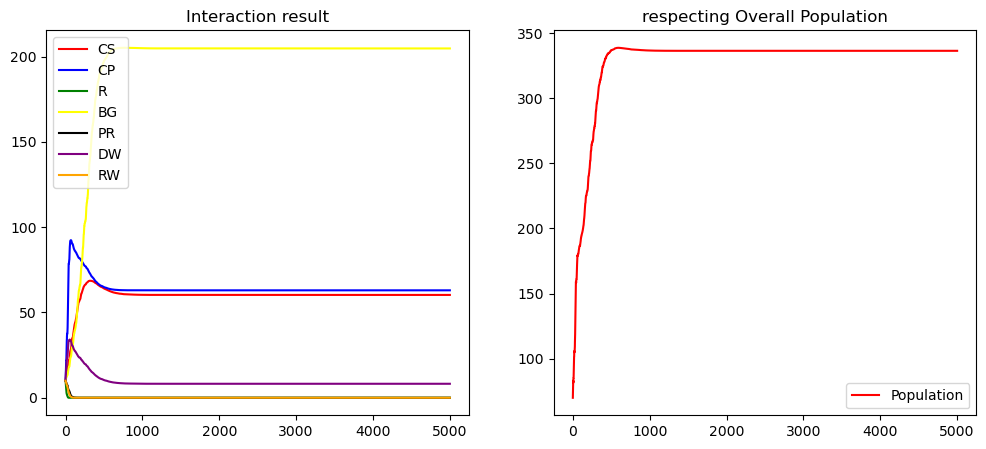

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 1000.0(changing init_Ci)
-----------------------


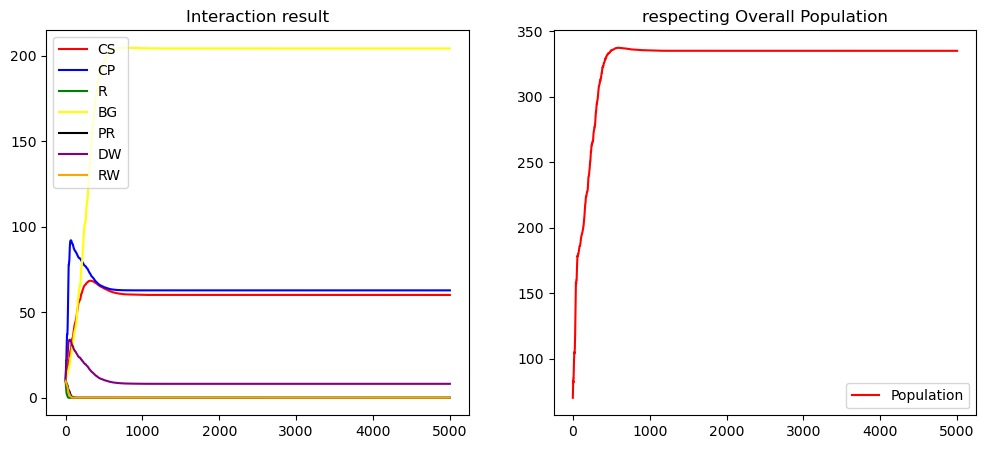

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 5000.0(changing init_Ci)
-----------------------


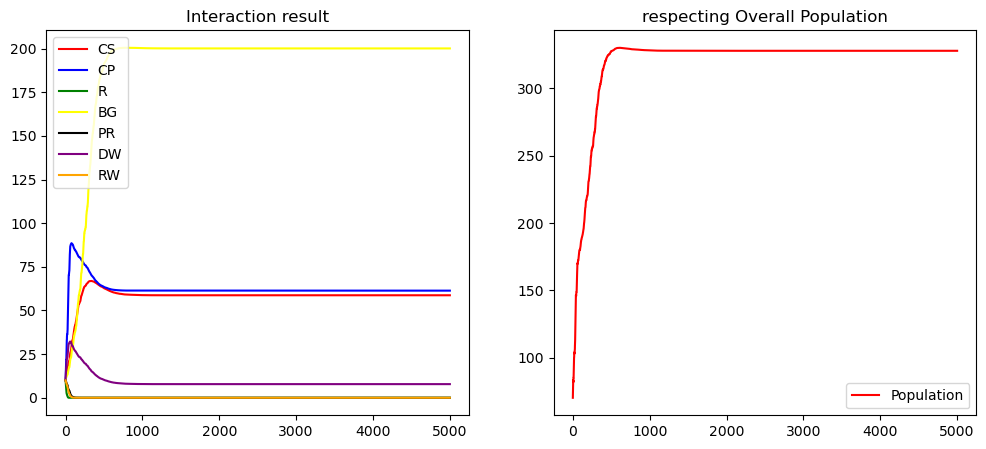

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 8000.0(changing init_Ci)
-----------------------


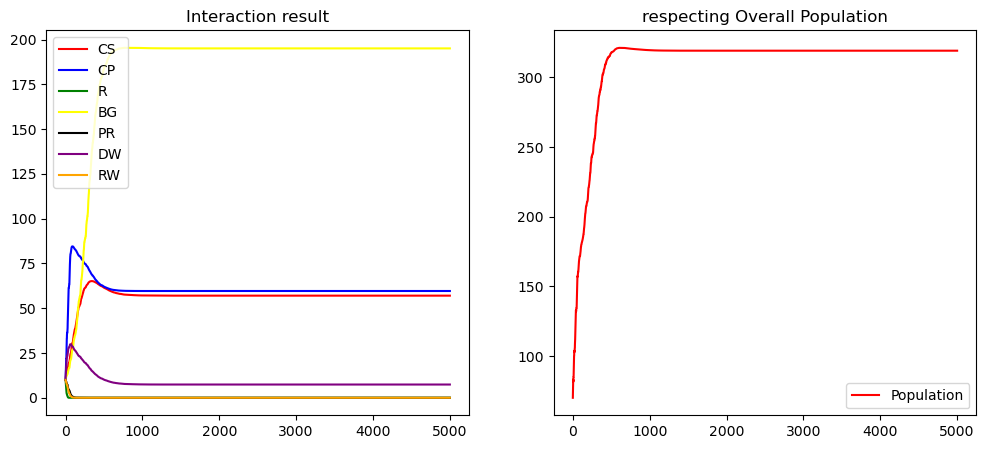

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 10000.0(changing init_Ci)
-----------------------


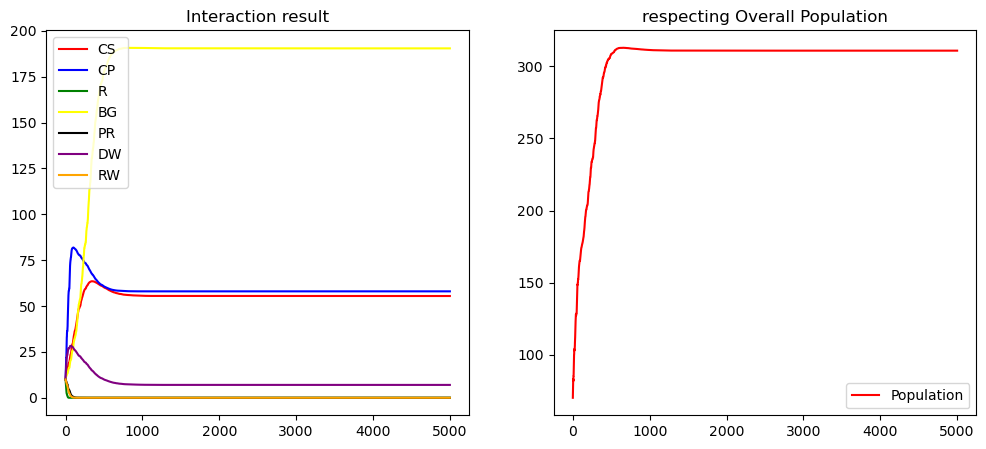

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 30000.0(changing init_Ci)
-----------------------


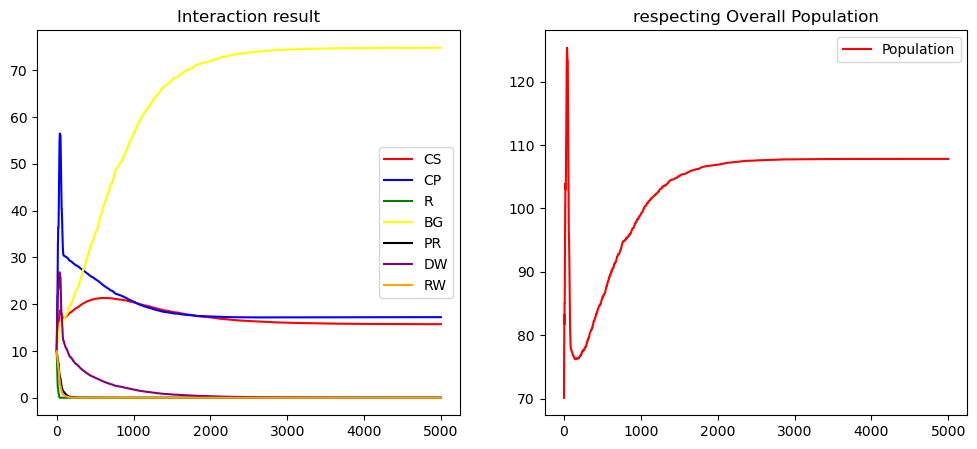

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 50000.0(changing init_Ci)
-----------------------


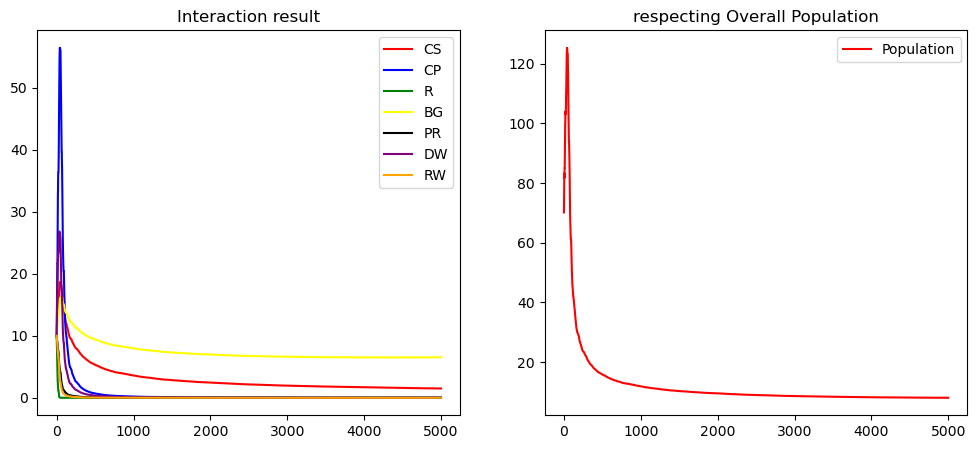

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 80000.0(changing init_Ci)
-----------------------


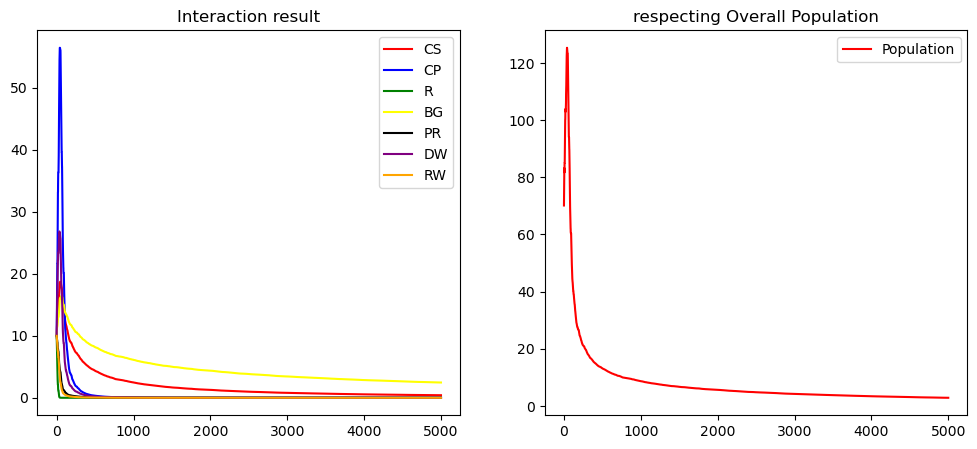

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


Interaction result with reduction rate = 0.2 and pollution point distance = 20 and initial Ci = 100000.0(changing init_Ci)
-----------------------


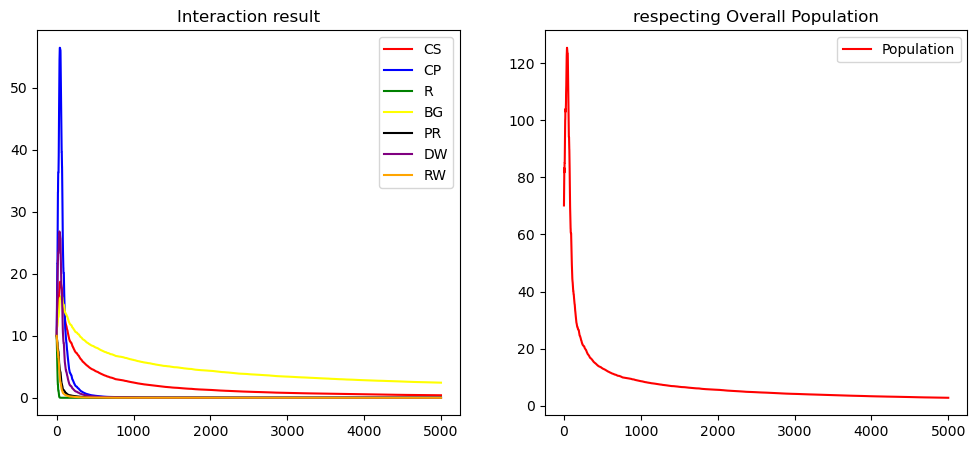

In [131]:
init_Ci_list = [1e2,1e3,5e3,8e3,1e4,3e4,5e4,8e4,1e5]
for Ci in init_Ci_list:
    init_Ci = Ci # should be large to see the effect
    pollution_point_distance = 20 # from 0 to 100
    init_radius = 1
    speed = 1
    reduction_rate = 0.2
    all_area_radius = 100 * (1-reduction_rate)
    P_list, time_span_before, time_span_in_between, time_span_after = pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate)
    print('Interaction result with reduction rate = ' + str(reduction_rate) + ' and pollution point distance = ' + str(pollution_point_distance)+' and initial Ci = ' + str(init_Ci) + "(changing init_Ci)")
    print("-----------------------")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Interaction result")
    plt.plot(time, cs_trend, color='red', label='CS')
    plt.plot(time, cp_trend, color='blue', label='CP')
    plt.plot(time, R_trend, color='green', label='R')
    plt.plot(time, BG_trend, color='yellow', label='BG')
    plt.plot(time, PR_trend, color='black', label='PR')
    plt.plot(time, DW_trend, color='purple', label='DW')
    plt.plot(time, RW_trend, color='orange', label='RW')
    plt.legend()
    population_list = [cs_trend[i] + cp_trend[i] + R_trend[i] + BG_trend[i] + PR_trend[i] + DW_trend[i] + RW_trend[i] for i in range(len(time))]
    plt.subplot(1, 2, 2)
    plt.title("respecting Overall Population")
    plt.plot(time, population_list, color='red', label='Population')
    plt.legend()
    plt.show()

with reduction rate = 0.2 and pollution point distance = 0and init_Ci=30000.0(changing pollution point distance)
-----------------------


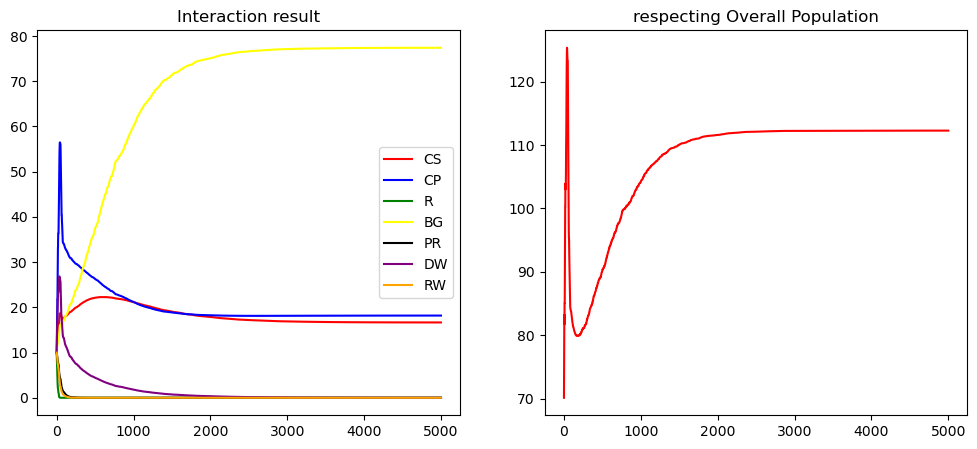

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.2 and pollution point distance = 20and init_Ci=30000.0(changing pollution point distance)
-----------------------


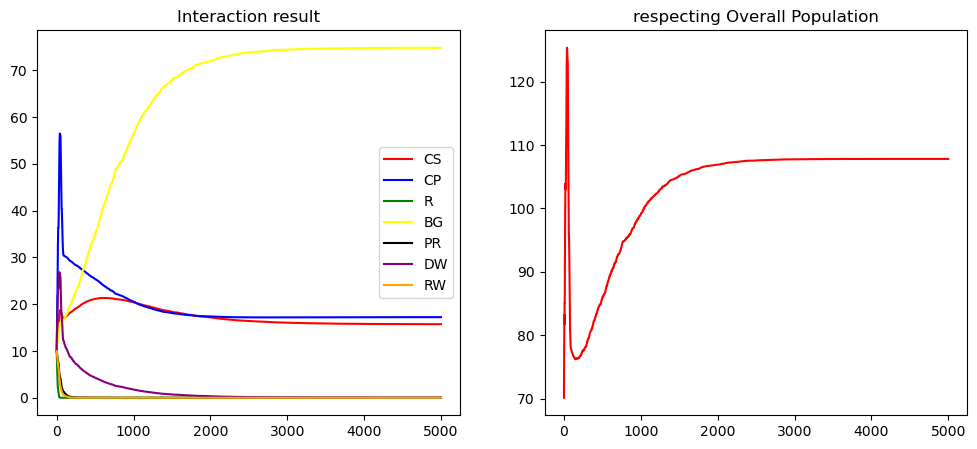

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.2 and pollution point distance = 40and init_Ci=30000.0(changing pollution point distance)
-----------------------


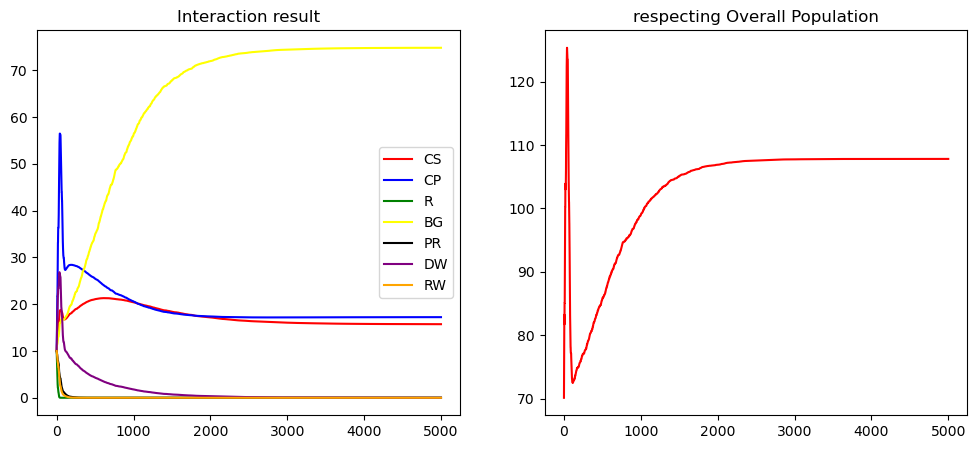

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.2 and pollution point distance = 60and init_Ci=30000.0(changing pollution point distance)
-----------------------


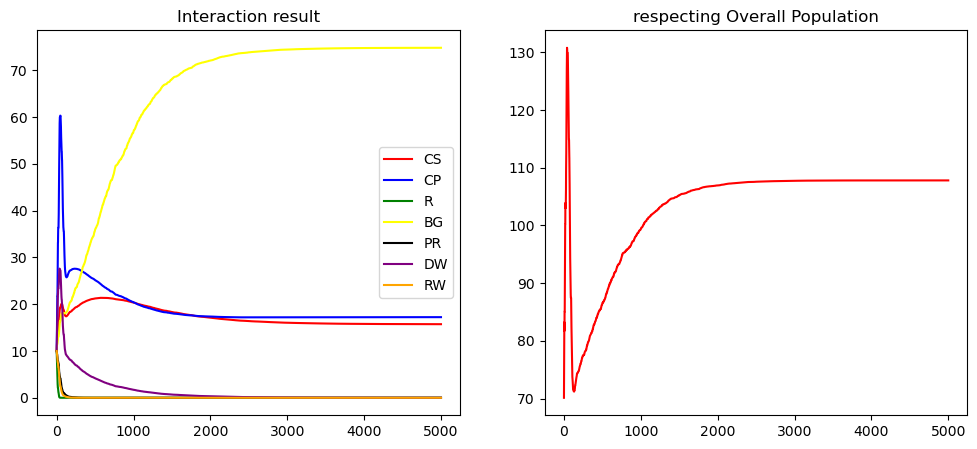

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.2 and pollution point distance = 80and init_Ci=30000.0(changing pollution point distance)
-----------------------


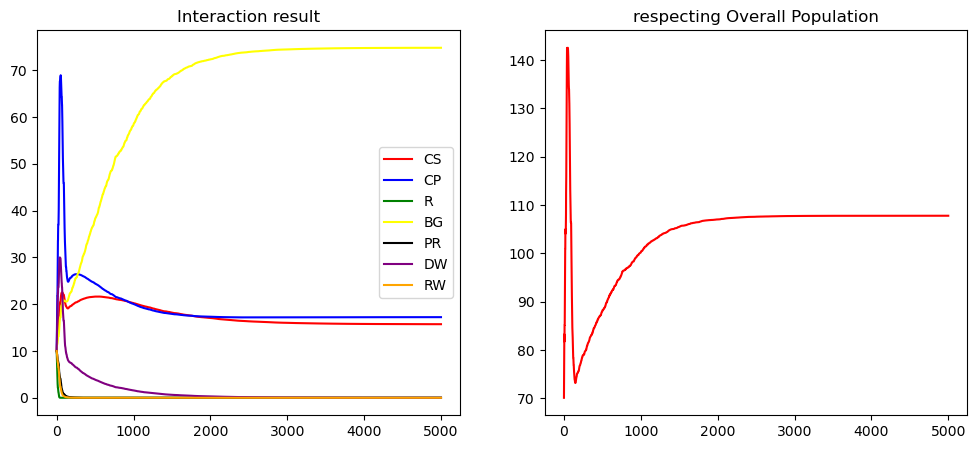

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np

with reduction rate = 0.2 and pollution point distance = 100and init_Ci=30000.0(changing pollution point distance)
-----------------------


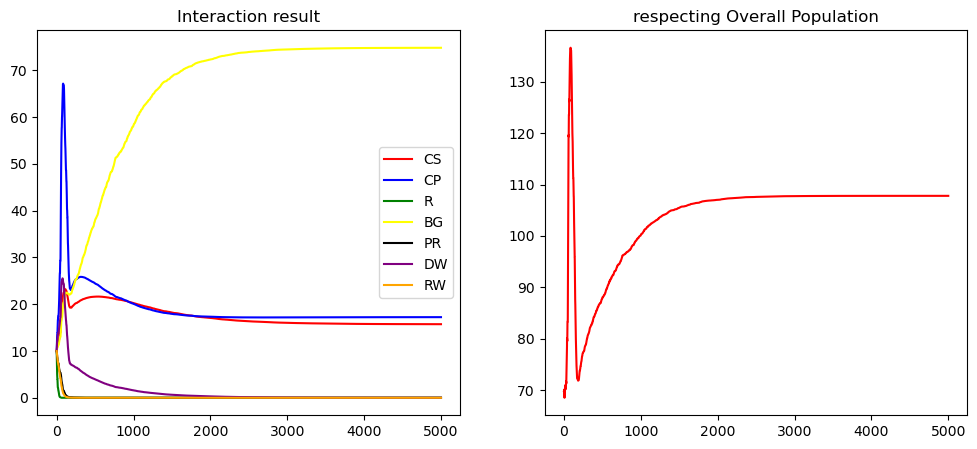

In [132]:
pollution_point_distance_list = [0,20,40,60,80,100]
for distance in pollution_point_distance_list:
    init_Ci = 3e4 # should be large to see the effect
    pollution_point_distance = distance 
    init_radius = 1
    speed = 1
    reduction_rate = 0.2
    all_area_radius = 100 * (1-reduction_rate)
    P_list, time_span_before, time_span_in_between, time_span_after = pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate)
    print('with reduction rate = ' + str(reduction_rate) + ' and pollution point distance = ' + str(pollution_point_distance) + "and init_Ci=" + str(init_Ci) +"(changing pollution point distance)")
    print("-----------------------")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Interaction result")
    plt.plot(time, cs_trend, color='red', label='CS')
    plt.plot(time, cp_trend, color='blue', label='CP')
    plt.plot(time, R_trend, color='green', label='R')
    plt.plot(time, BG_trend, color='yellow', label='BG')
    plt.plot(time, PR_trend, color='black', label='PR')
    plt.plot(time, DW_trend, color='purple', label='DW')
    plt.plot(time, RW_trend, color='orange', label='RW')
    plt.legend()
    population_list = [cs_trend[i] + cp_trend[i] + R_trend[i] + BG_trend[i] + PR_trend[i] + DW_trend[i] + RW_trend[i] for i in range(len(time))]
    plt.subplot(1, 2, 2)
    plt.title("respecting Overall Population")
    plt.plot(time, population_list, color='red', label='Population')
    plt.show()

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0 and pollution point distance = 20and init_Ci=30000.0(changing reduction rate)
-----------------------


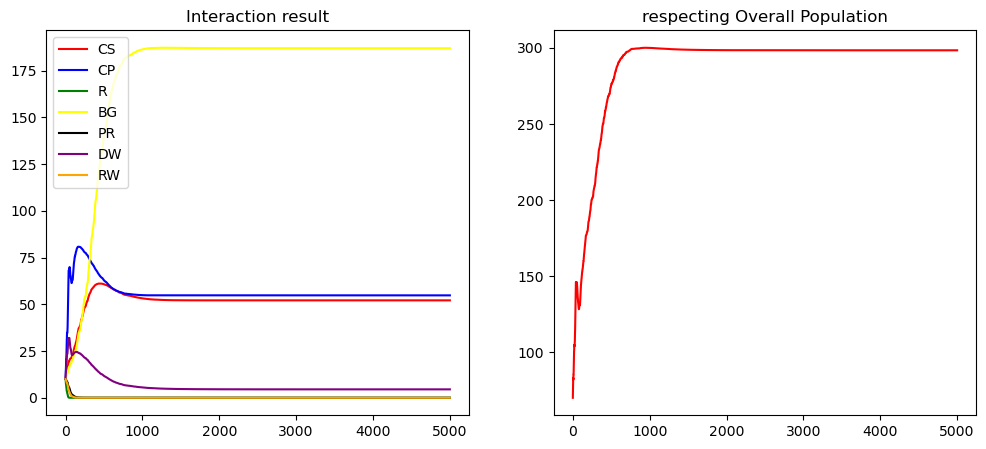

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.2 and pollution point distance = 20and init_Ci=30000.0(changing reduction rate)
-----------------------


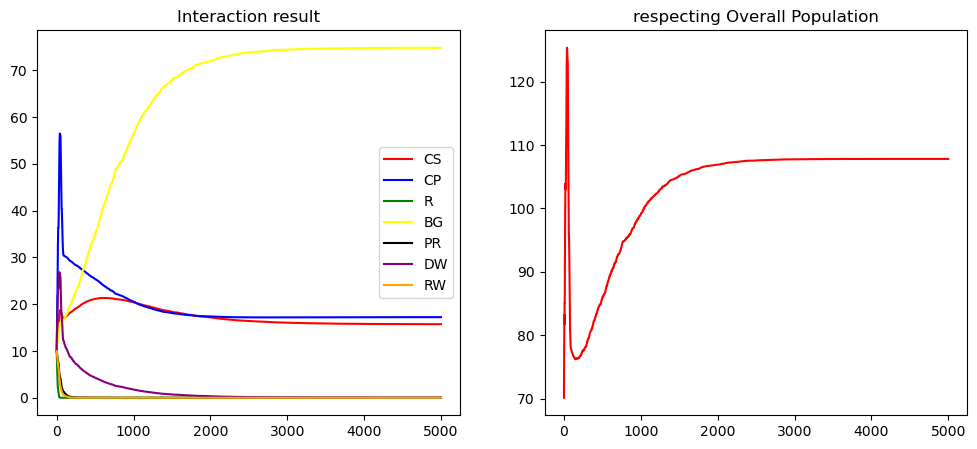

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.4 and pollution point distance = 20and init_Ci=30000.0(changing reduction rate)
-----------------------


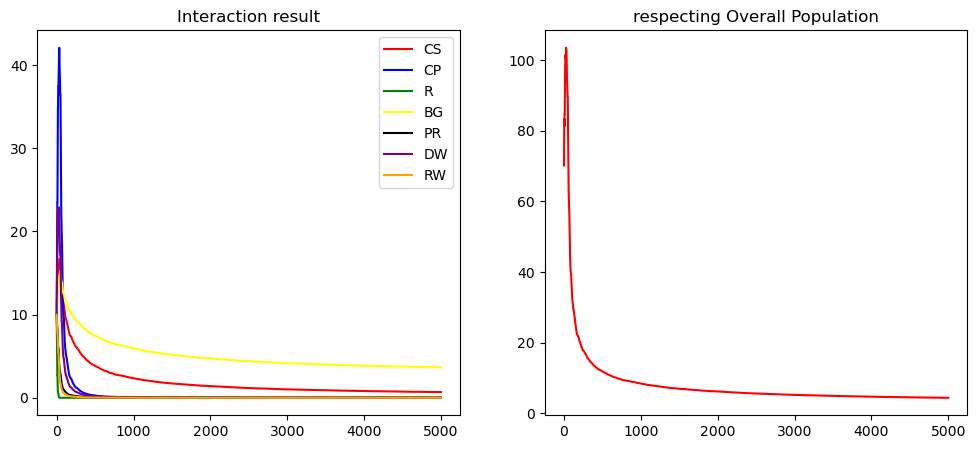

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.6 and pollution point distance = 20and init_Ci=30000.0(changing reduction rate)
-----------------------


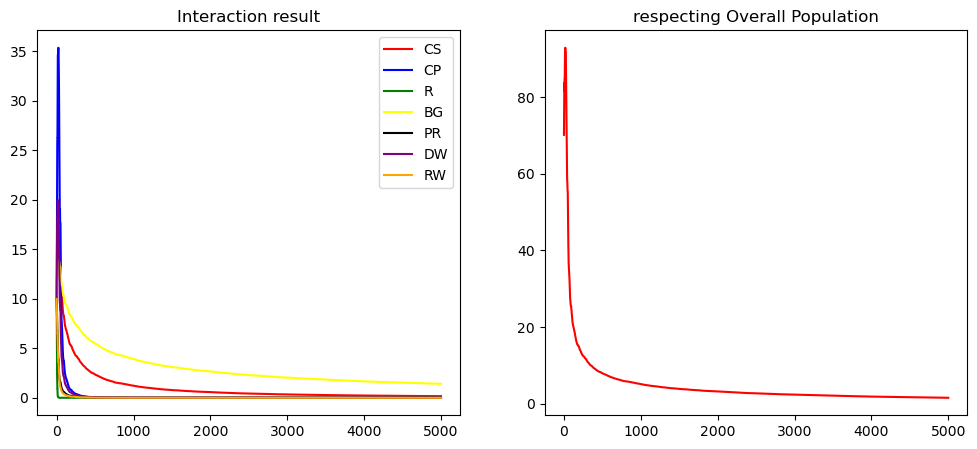

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.8 and pollution point distance = 20and init_Ci=30000.0(changing reduction rate)
-----------------------


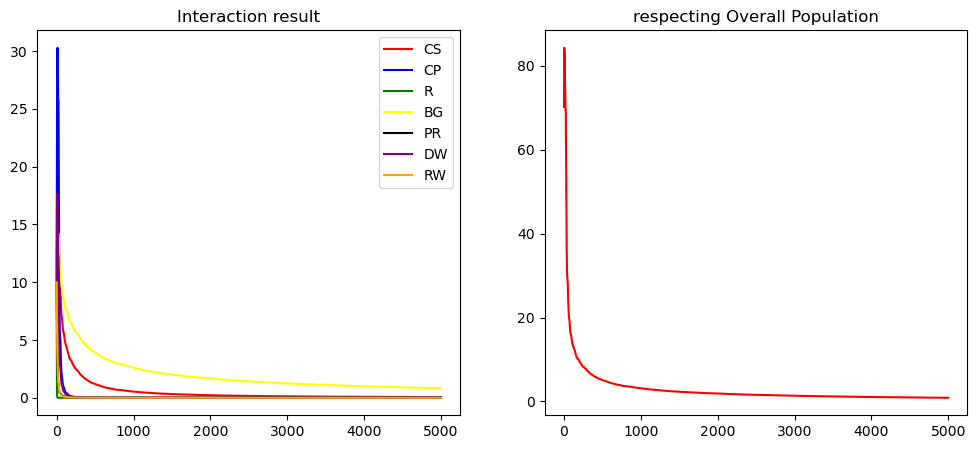

In [133]:
reduction_rate_list = [0,0.2,0.4,0.6,0.8]
for reduction in reduction_rate_list:
    init_Ci = 3e4 # should be large to see the effect
    pollution_point_distance = 20
    init_radius = 1
    speed = 1
    reduction_rate = reduction
    all_area_radius = 100 * (1-reduction_rate)
    P_list, time_span_before, time_span_in_between, time_span_after = pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate)
    print('with reduction rate = ' + str(reduction_rate) + ' and pollution point distance = ' + str(pollution_point_distance) + "and init_Ci=" + str(init_Ci) +"(changing reduction rate)")
    print("-----------------------")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Interaction result")
    plt.plot(time, cs_trend, color='red', label='CS')
    plt.plot(time, cp_trend, color='blue', label='CP')
    plt.plot(time, R_trend, color='green', label='R')
    plt.plot(time, BG_trend, color='yellow', label='BG')
    plt.plot(time, PR_trend, color='black', label='PR')
    plt.plot(time, DW_trend, color='purple', label='DW')
    plt.plot(time, RW_trend, color='orange', label='RW')
    plt.legend()
    population_list = [cs_trend[i] + cp_trend[i] + R_trend[i] + BG_trend[i] + PR_trend[i] + DW_trend[i] + RW_trend[i] for i in range(len(time))]
    plt.subplot(1, 2, 2)
    plt.title("respecting Overall Population")
    plt.plot(time, population_list, color='red', label='Population')
    plt.show()

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_

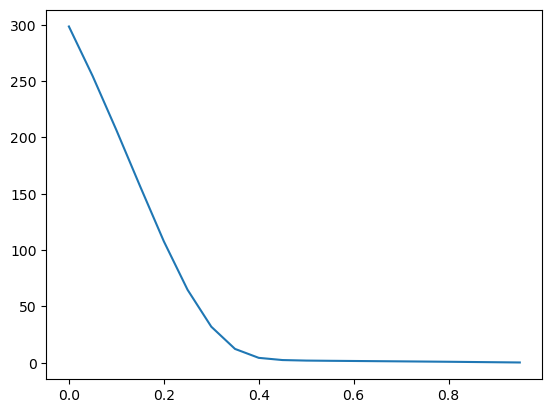

In [134]:
reduction_rate_list = np.arange(0,1,0.05)
final_population_list = []
for reduction in reduction_rate_list:
    init_Ci = 3e4 # should be large to see the effect
    pollution_point_distance = 20
    init_radius = 1
    speed = 1
    reduction_rate = reduction
    all_area_radius = 100 * (1-reduction_rate)
    P_list, time_span_before, time_span_in_between, time_span_after = pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate)
    population_list = [cs_trend[i] + cp_trend[i] + R_trend[i] + BG_trend[i] + PR_trend[i] + DW_trend[i] + RW_trend[i] for i in range(len(time))]
    final_population_list.append(population_list[-1])
plt.plot(reduction_rate_list, final_population_list)

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0 and pollution point distance = 20and init_Ci=0(changing reduction rate)
-----------------------


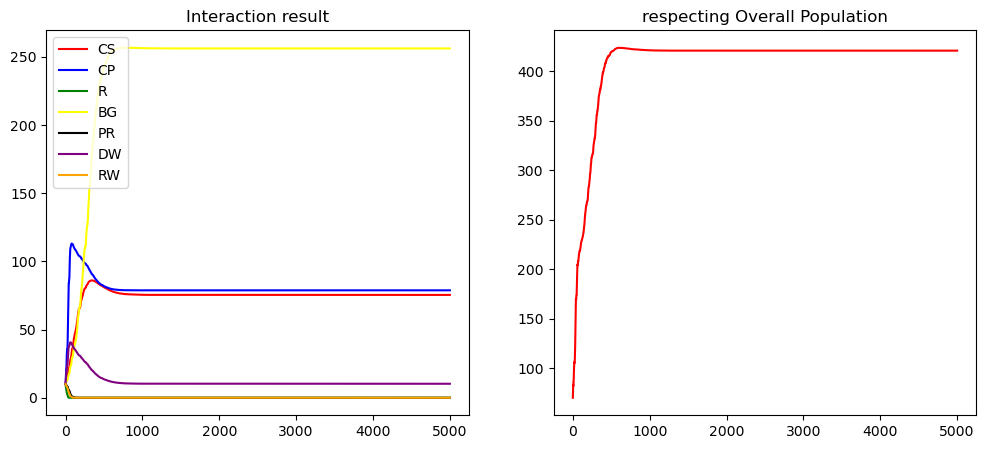

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.2 and pollution point distance = 20and init_Ci=0(changing reduction rate)
-----------------------


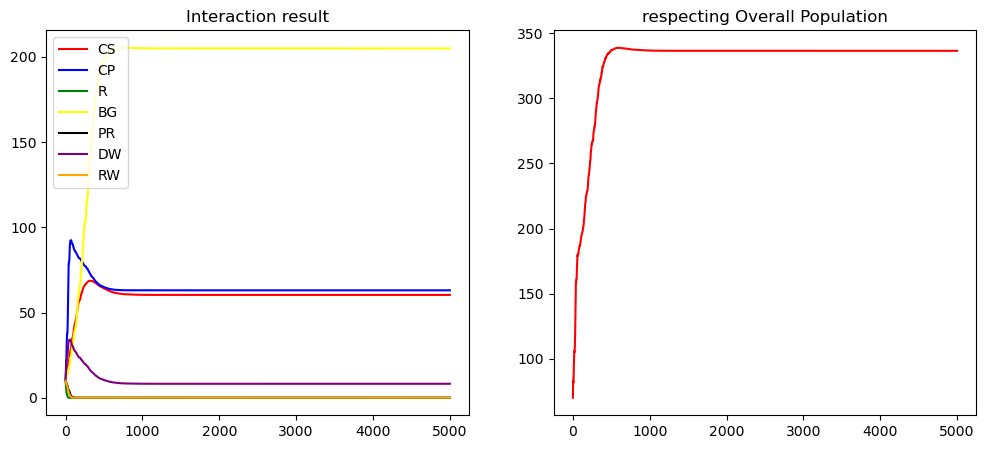

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.4 and pollution point distance = 20and init_Ci=0(changing reduction rate)
-----------------------


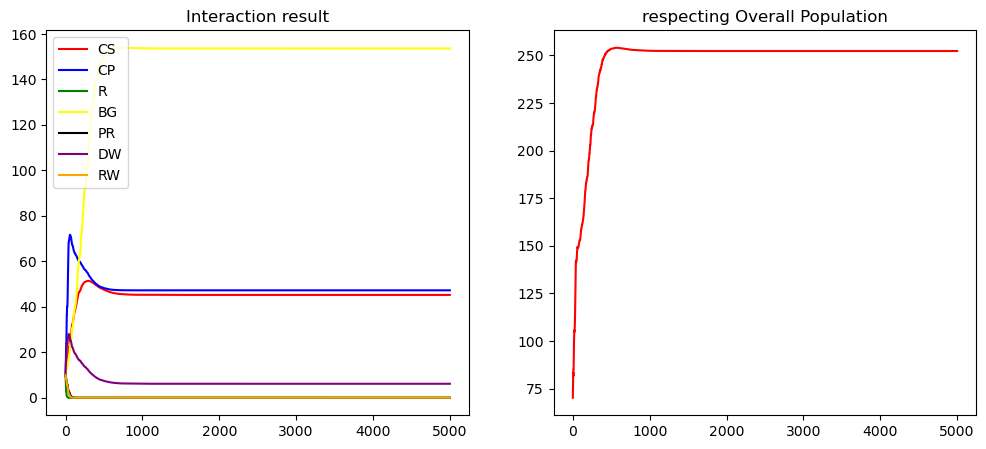

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.6 and pollution point distance = 20and init_Ci=0(changing reduction rate)
-----------------------


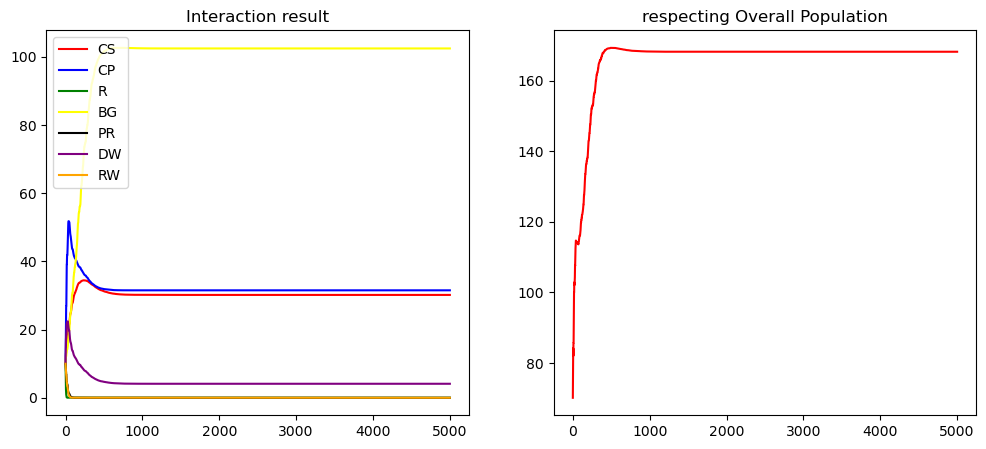

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))


with reduction rate = 0.8 and pollution point distance = 20and init_Ci=0(changing reduction rate)
-----------------------


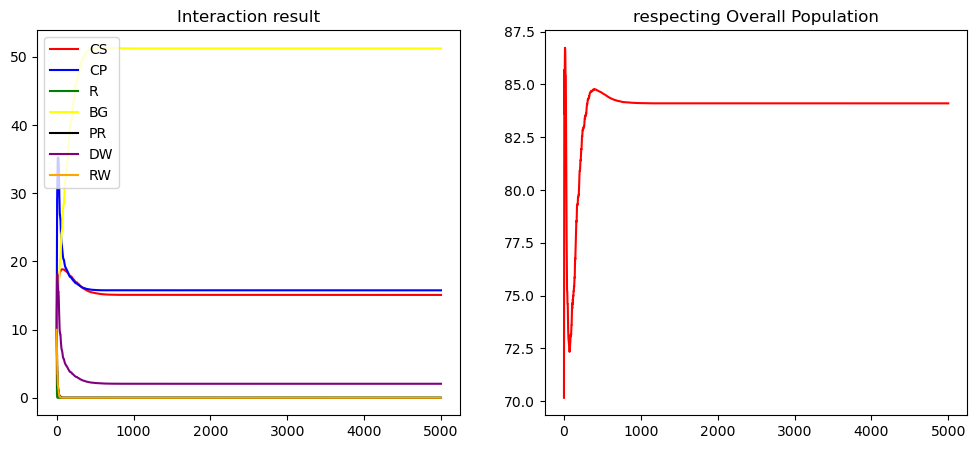

In [135]:
reduction_rate_list = [0,0.2,0.4,0.6,0.8]
for reduction in reduction_rate_list:
    init_Ci = 0 # no pollution here, see what happens
    pollution_point_distance = 20
    init_radius = 1
    speed = 1
    reduction_rate = reduction
    all_area_radius = 100 * (1-reduction_rate)
    P_list, time_span_before, time_span_in_between, time_span_after = pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate)
    print('with reduction rate = ' + str(reduction_rate) + ' and pollution point distance = ' + str(pollution_point_distance) + "and init_Ci=" + str(init_Ci) +"(changing reduction rate)")
    print("-----------------------")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title("Interaction result")
    plt.plot(time, cs_trend, color='red', label='CS')
    plt.plot(time, cp_trend, color='blue', label='CP')
    plt.plot(time, R_trend, color='green', label='R')
    plt.plot(time, BG_trend, color='yellow', label='BG')
    plt.plot(time, PR_trend, color='black', label='PR')
    plt.plot(time, DW_trend, color='purple', label='DW')
    plt.plot(time, RW_trend, color='orange', label='RW')
    plt.legend()
    population_list = [cs_trend[i] + cp_trend[i] + R_trend[i] + BG_trend[i] + PR_trend[i] + DW_trend[i] + RW_trend[i] for i in range(len(time))]
    plt.subplot(1, 2, 2)
    plt.title("respecting Overall Population")
    plt.plot(time, population_list, color='red', label='Population')
    plt.show()

/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_larger**2 * np.arccos((distance_of_center**2 + r_larger**2 - r_smaller**2) / (2 * distance_of_center * r_larger))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:28: RuntimeWarning: invalid value encountered in arccos
  + r_smaller**2 * np.arccos((distance_of_center**2 + r_smaller**2 - r_larger**2) / (2 * distance_of_center * r_smaller))\
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:29: RuntimeWarning: invalid value encountered in sqrt
  - 0.5 * np.sqrt((-distance_of_center + r_larger + r_smaller) * (distance_of_center + r_larger - r_smaller) * (distance_of_center - r_larger + r_smaller) * (distance_of_center + r_larger + r_smaller))
/var/folders/hs/hk_yx7yd6g1dvcsdd3rksqk40000gn/T/ipykernel_40258/4024729606.py:27: RuntimeWarning: invalid value encountered in arccos
  area = r_

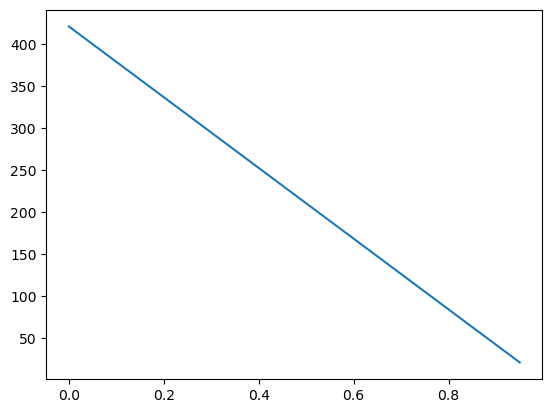

In [136]:
reduction_rate_list = np.arange(0,1,0.05)
final_population_list = []
for reduction in reduction_rate_list:
    init_Ci = 0 # no pollution here, see what happens
    pollution_point_distance = 20
    init_radius = 1
    speed = 1
    reduction_rate = reduction
    all_area_radius = 100 * (1-reduction_rate)
    P_list, time_span_before, time_span_in_between, time_span_after = pollution_model(all_area_radius, init_Ci, pollution_point_distance, init_radius, speed)
    cs_trend, cp_trend, R_trend, BG_trend, PR_trend, DW_trend, RW_trend = doCompetitionModelWithPollutionAndReduction(P_list, reduction_rate)
    population_list = [cs_trend[i] + cp_trend[i] + R_trend[i] + BG_trend[i] + PR_trend[i] + DW_trend[i] + RW_trend[i] for i in range(len(time))]
    final_population_list.append(population_list[-1])
plt.plot(reduction_rate_list, final_population_list)